In [ ]:
import cvxpy as cp
import numpy as np
import math
import pandas as pd
import itertools
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

<h1> Taking the home input </h1>

In [53]:
home = raw_input("Which Home:")
file_path = 'Year1/Home' + home + '_yr1.csv'

Which Home:1


In [54]:
dft = pd.read_csv(file_path, names=['Actual'])
intervals = pd.date_range(start='12/1/2014', end='12/1/2015', freq='15min', closed=None)[0:-1]
dft.insert(0, 'Timestamp', intervals)
dft = dft.set_index('Timestamp')

<h1> Taking the time stamp input (November 1st to November 7th) </h1>

In [173]:
year = raw_input("Enter the Year:")
month = raw_input("Enter the Month:")
date = raw_input("Enter the Date:")
hour = raw_input("Enter the Hour:")
minute = raw_input("Enter the Minute:")
date1 = datetime(int(year), int(month), int(date), int(hour), int(minute) , 0)
print(date1)
end_dt = date1 + timedelta(days=7) - timedelta(minutes=15)
print(end_dt)
training_dataset = dft[: date1 - timedelta(minutes=15)]
dataset = dft[date1:end_dt]
y = dataset['Actual'].tolist()

Enter the Year:2015
Enter the Month:11
Enter the Date:1
Enter the Hour:0
Enter the Minute:0
2015-11-01 00:00:00
2015-11-07 23:45:00


<h1> Offline Dynamic Algorithm </h1>

In [16]:
p = 0.1
a = 1
x = cp.Variable(672)
sum = 0
for i in range(1,672):
    sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
objective = (cp.Minimize(sum))
constraints = [0 <= x]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print(result)

196.90778135184453


<h1> Home 1 - Offline Dynamic Provisioning Plot </h1>

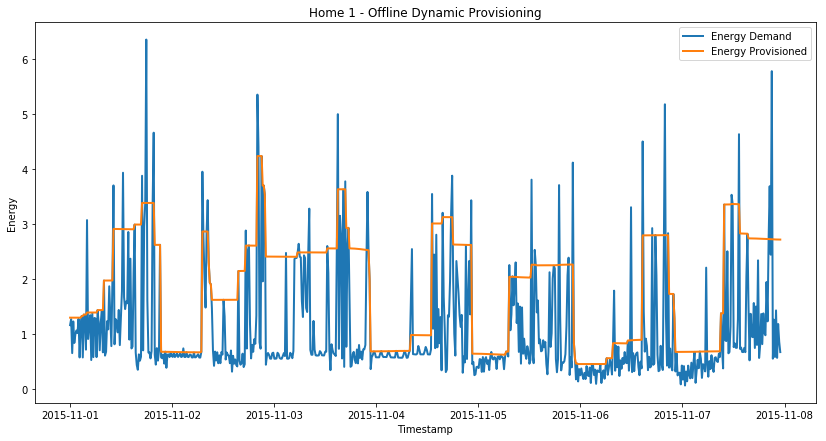

In [20]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Provisioned': x.value}) 
OD['Energy Demand'] = y
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], linewidth=2, label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=2, label="Energy Provisioned")
plt.title('Home 1 - Offline Dynamic Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Home 1 - Offline Static Provisioning </h1>

In [21]:
p = 0.1
a = 1
# use the y as directly from the house values
y = dataset['Actual'].tolist()
x_S = cp.Variable(672)

equation = p*x_S + a*(cp.maximum(0,cp.exp(y-x_S)))
objective = cp.Minimize(cp.sum(equation))
constraints = [0 <= x_S]
prob = cp.Problem(objective, constraints)
result = prob.solve()
print(result)

293.0769063107693


<h1> Home 1 - Offline Static Provisioning Plot </h1>

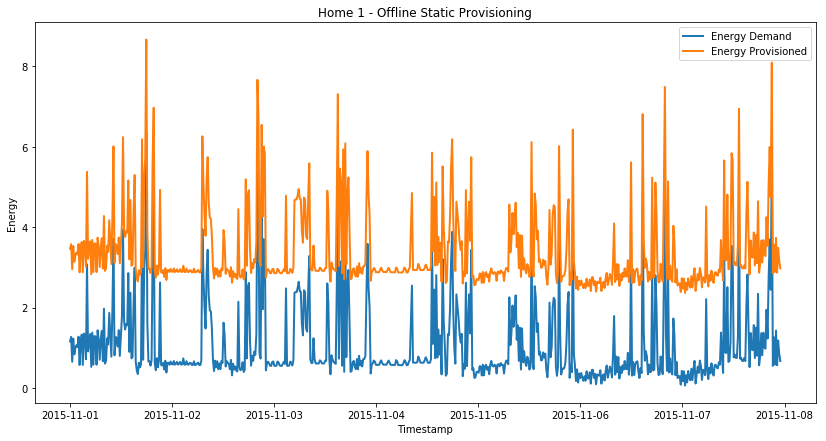

In [22]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Provisioned': x_S.value}) 
OD['Energy Demand'] = y
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], linewidth=2, label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=2, label="Energy Provisioned")
plt.title('Home 1 - Offline Static Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Home 1 - Online Gradient Descent Provisioning </h1>

In [56]:
def df1(y , x1 , x2):
    if y > x1:
        if(x1 > x2):
            return p - a + b
        else:
            return p - a - b
    else:
        if(x1 > x2):
            return p + b
        else:
            return p - b

a = 1
b = 1
p = 0.1
c = 0.01
n = 0.055

x = [0]
for i in range(1,672):
    x.append(x[i-1] - (n * df1(y[i-1], x[i-1] , x[i-2])))
cost = 0
for i in range(0,len(x)):
    cost += p*x[i] + a*max(0, y[i] - x[i]) + b* abs(x[i] - x[i-1])
    
print(cost)

285.29625


<h1> Home 1 - Online Gradient Descent Provisioning Plot </h1>

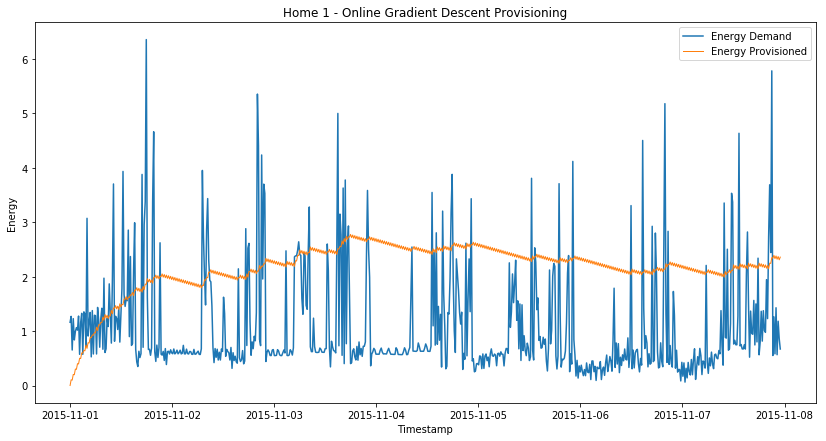

In [57]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Demand': y }) 
OD['Energy Provisioned'] = x
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=1, label="Energy Provisioned")
plt.title('Home 1 - Online Gradient Descent Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Home 1 - Sensitivity analysis for Online Gradient Descent Provisioning </h1>

In [26]:
def df1(y , x1 , x2):
    if y > x1:
        if(x1 > x2):
            return p - a + b
        else:
            return p - a - b
    else:
        if(x1 > x2):
            return p + b
        else:
            return p - b

def eta(i):
    return c/math.sqrt(i)

a = 1
b = 1
p = 0.1
c = 0.01
ETA = []
j = 0.001

while j < 1:
    ETA.append(j)
    j = j + 0.005
    
costs = []
for n in ETA:
    x = [0]
    for i in range(1,672):
        x.append(x[i-1] - (n * df1(y[i-1], x[i-1] , x[i-2])))
    cost = 0
    for i in range(0,len(x)):
        cost += p*x[i] + a*max(0, y[i] - x[i]) + b* abs(x[i] - x[i-1])
    costs.append(cost)

<h1> Home 1 - Sensitivity analysis for Online Gradient Descent Provisioning </h1>

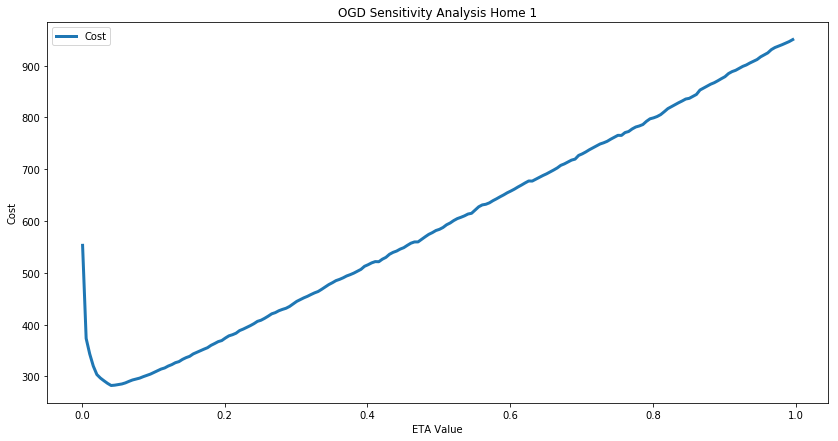

In [28]:
OD = pd.DataFrame({'Cost': costs }) 
OD['Eta Value'] = ETA
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['Eta Value'], OD['Cost'], linewidth = 3, label="Cost")
plt.title('OGD Sensitivity Analysis Home 1')
plt.xlabel('ETA Value')
plt.ylabel('Cost')
plt.legend()
plt.show()

<h1> Loading prediction data for ARIMA and AdaBoost </h1>

In [31]:
y_pred_arima = np.loadtxt("y_arima_pred_house1.csv")
y_pred_adaboost = np.loadtxt("y_adaboost_pred_house1.csv")

<h1> Home 1 - Receding Horizon Control Algorithm with ARIMA predictions </h1>

In [58]:
p = 0.1
a = 1
w = 12
X_1 = [0]

for t in range(1,672):
    y = y_pred_arima[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    X_1.append(x.value[0])

In [61]:
rhc_cost_arima = 0
for i in range(1,len(X_1)):
    rhc_cost_arima += p*X_1[i] + a*max(0, y_pred_arima[i] - X_1[i]) + b*abs(X_1[i] - X_1[i-1])
print(rhc_cost_arima)

90.64281806022578


<h1> Home 1 - Commitment Horizon Control Algorithm with ARIMA predictions </h1>

In [59]:
p = 0.1
a = 1
w = 12
v = 2
b = 1
X_3 = [0]
for t in range(1,672):
    y = y_pred_arima[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + a*cp.maximum(0, y[i]-x[i]) + b*cp.abs(x[i] - x[i-1]))

    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for i in range(0,v):
        avg += x.value[i]/v
    X_3.append(avg)

In [62]:
chc_cost_arima = 0
for i in range(1,len(X_3)):
    chc_cost_arima += p*X_3[i] + a*max(0, y_pred_arima[i] - X_3[i]) + b*abs(X_3[i] - X_3[i-1])
print(chc_cost_arima)

90.64211481486008


<h1> Home 1 Plot - RHC vs CHC with ARIMA predictions </h1>

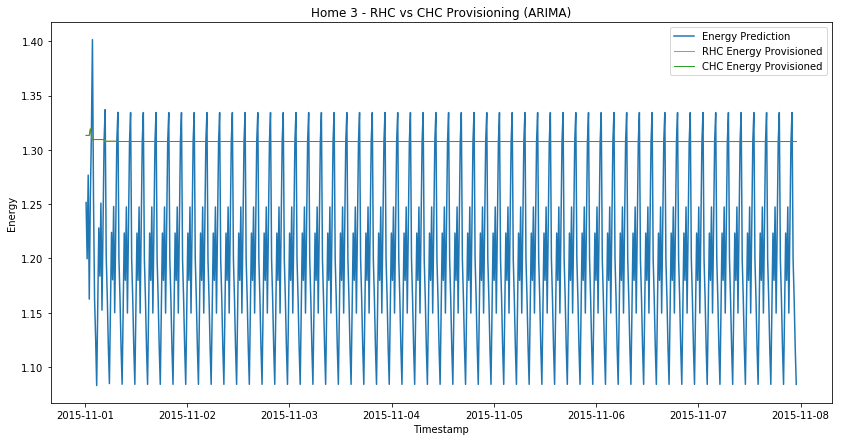

In [63]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Prediction': y_pred_arima[1:672]}) 
OD['RHC Energy Provisioned'] = X_1[1:672]
OD['CHC Energy Provisioned'] = X_3[1:672]
OD['TimeStamp'] = dur[1:672]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Prediction'], label="Energy Prediction")
plt.plot(OD['TimeStamp'], OD['RHC Energy Provisioned'], linewidth=1, label="RHC Energy Provisioned")
plt.plot(OD['TimeStamp'], OD['CHC Energy Provisioned'], linewidth=1, label="CHC Energy Provisioned")
plt.title('Home 3 - RHC vs CHC Provisioning (ARIMA)')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Home 1 - Receding Horizon Control Algorithm with Adaboost predictions </h1>

In [37]:
p = 0.1
a = 1
w = 5
X_2 = [0]

for t in range(1,672):
    y = y_pred_adaboost[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    X_2.append(x.value[0])


In [38]:
rhc_cost_adb = 0
for i in range(1,len(X_2)):
    rhc_cost_adb += p*X_2[i] + a*max(0, y_pred_adaboost[i] - X_2[i]) + b*abs(X_2[i] - X_2[i-1])
print(rhc_cost_adb)

204.60625877683765


<h1> Home 1 - Commitment Horizon Control Algorithm with Adaboost predictions </h1>


In [39]:
p = 0.1
a = 1
w = 5
v = 2
X_4 = [0]

for t in range(1,672):
    y = y_pred_adaboost[t:t+w]
    x = cp.Variable(w)
    sum = 0
    for i in range(0,w):
        sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))
    
    objective = (cp.Minimize(sum))
    constraints = [0 <= x]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()
    avg = 0
    for i in range(0,v):
        avg += x.value[i]/v
    X_4.append(avg)

In [40]:
chc_cost_adb = 0
for i in range(1,len(X_4)):
    chc_cost_adb += p*X_4[i] + a*max(0, y_pred_adaboost[i] - X_4[i]) + b*abs(X_4[i] - X_4[i-1])
print(chc_cost_adb)

204.60515899595535


<h1> Home 1 Plot - RHC vs CHC with Adaboost predictions </h1>

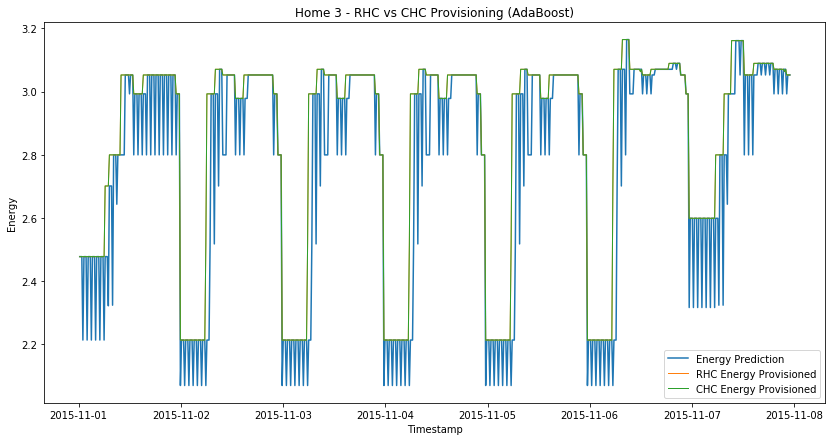

In [64]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 672).tolist()]
OD = pd.DataFrame({'Energy Prediction': y_pred_adaboost[1:672]}) 
OD['RHC Energy Provisioned'] = X_2[1:672]
OD['CHC Energy Provisioned'] = X_4[1:672]
OD['TimeStamp'] = dur[1:672]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Prediction'], label="Energy Prediction")
plt.plot(OD['TimeStamp'], OD['RHC Energy Provisioned'], linewidth=1, label="RHC Energy Provisioned")
plt.plot(OD['TimeStamp'], OD['CHC Energy Provisioned'], linewidth=1, label="CHC Energy Provisioned")
plt.title('Home 3 - RHC vs CHC Provisioning (AdaBoost)')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Sensitivity Analysis for RHC with Arima predictions </h1>

In [65]:
p = 0.1
a = 1
b = 1
window_sensitivity_dict = {}
for w in range(1,20):
    X_1 = [0]
    for t in range(1,672):
        y = y_pred_arima[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        X_1.append(x.value[0])
    rhc_cost_arima = 0
    for i in range(1,len(X_1)):
        rhc_cost_arima += p*X_1[i] + a*max(0, y_pred_arima[i] - X_1[i]) + b*abs(X_1[i] - X_1[i-1])
    window_sensitivity_dict[w] = rhc_cost_arima

<h1> Sensitivity Analysis Plot for RHC with Arima predictions varying "w" </h1>

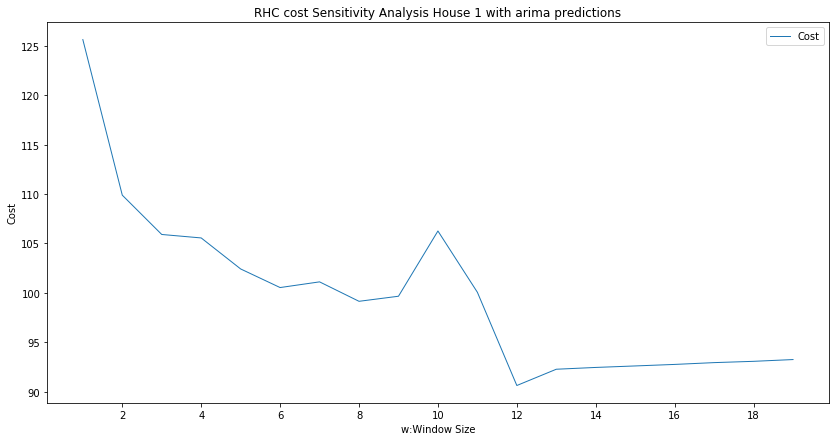

In [67]:
w_values = range(1, 20)
cost_w_vary = window_sensitivity_dict.values()
OD = pd.DataFrame({'Window Size': w_values }) 
OD['Cost'] = cost_w_vary
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.xticks(np.arange(0, 20, 2))
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['Window Size'], OD['Cost'], linewidth = 1, label="Cost")
plt.title('RHC cost Sensitivity Analysis House 1 with arima predictions')
plt.xlabel('w:Window Size')
plt.ylabel('Cost')
plt.legend()
plt.show()

<h1> Sensitivity Analysis for CHC with Arima predictions </h1>

In [ ]:
p = 0.1
a = 1
b = 1
w = 12
commitment_sensitivity_dict = {}
for v in range(1,12):
    X_3 = [0]
    for t in range(1,672):
        y = y_pred_arima[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        avg = 0
        for i in range(0,v):
            avg += x.value[i]/v
        X_3.append(avg)
    chc_cost_arima = 0
    for i in range(1,len(X_3)):
        chc_cost_arima += p*X_3[i] + a*max(0, y_pred_arima[i] - X_3[i]) + b*abs(X_3[i] - X_3[i-1])
    commitment_sensitivity_dict[v] = chc_cost_arima

<h1> Sensitivity Analysis Plot for CHC with Arima predictions varying "w" </h1>

In [ ]:
v_values = range(1, 12)
cost_v_vary = commitment_sensitivity_dict.values()
OD = pd.DataFrame({'Commitment Window Size': v_values }) 
OD['Cost'] = cost_v_vary
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['Commitment Window Size'], OD['Cost'], linewidth = 1, label="Cost")
plt.title('CHC cost Sensitivity Analysis House 1 with arima predictions and window size 12')
plt.xlabel('v:Commitment Window Size')
plt.ylabel('Cost')
plt.legend()
plt.show()

<img src="Screenshots/chc_arima_house1_vary_v.PNG">

<h1> Sensitivity Analysis for RHC with Adaboost predictions </h1>

In [ ]:
p = 0.1
a = 1
b = 1
window_sensitivity_dict_adb = {}
for w in range(1,20):
    X_2 = [0]
    for t in range(1,672):
        y = y_pred_adaboost[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        X_2.append(x.value[0])
    rhc_cost_adb = 0
    for i in range(1,len(X_2)):
        rhc_cost_adb += p*X_2[i] + a*max(0, y_pred_adaboost[i] - X_2[i]) + b*abs(X_2[i] - X_2[i-1])
    window_sensitivity_dict_adb[w] = rhc_cost_adb

<h1> Sensitivity Analysis Plot for RHC with Adaboost predictions varying "w" </h1>

In [ ]:
w_values = range(1, 20)
adb_cost_w_vary = window_sensitivity_dict_adb.values()
OD = pd.DataFrame({'Window Size': w_values }) 
OD['Cost'] = adb_cost_w_vary
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.xticks(np.arange(0, 20, 2))
plt.plot(OD['Window Size'], OD['Cost'], linewidth = 1, label="Cost")
plt.title('RHC cost Sensitivity Analysis House 1 with adaboost predictions')
plt.xlabel('w:Window Size')
plt.ylabel('Cost')
plt.legend()
plt.show()

<img src="Screenshots/rhc_adaboost_house1_vary_w.PNG">

<h1> Sensitivity Analysis for CHC with Adaboost predictions </h1>

In [ ]:
p = 0.1
a = 1
w = 5
commitment_sensitivity_dict_adb = {}
for v in range(1,w+1): 
    X_4 = [0]
    for t in range(1,672):
        y = y_pred_adaboost[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + cp.maximum(0, y[i]-x[i]) + cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        avg = 0
        for i in range(0,v):
            avg += x.value[i]/v
        X_4.append(avg)
    chc_cost_adb = 0
    for i in range(1,len(X_4)):
        chc_cost_adb += p*X_4[i] + a*max(0, y_pred_adaboost[i] - X_4[i]) + b*abs(X_4[i] - X_4[i-1])
    commitment_sensitivity_dict_adb[v] = chc_cost_adb

<h1> Sensitivity Analysis Plot for CHC with Adaboost predictions </h1>

In [ ]:
v_values = range(1, 6)
adb_cost_v_vary = commitment_sensitivity_dict_adb.values()
OD = pd.DataFrame({'Commitment Window Size': v_values }) 
OD['Cost'] = adb_cost_v_vary
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['Commitment Window Size'], OD['Cost'], linewidth = 1, label="Cost")
plt.title('CHC cost Sensitivity Analysis House 1 with adaboost predictions and window size 5')
plt.xlabel('v:Commitment Window Size')
plt.ylabel('Cost')
plt.legend()
plt.show()

<img src="Screenshots/chc_adaboost_house1_vary_v.PNG">

<h1> Best Algorithm - Home 1 - CHC with ARIMA predictions (w = 12 , v = 2) Varying "a" with constant "b" </h1>

In [ ]:
p = 0.1
a = 0.25
w = 12
v = 2
b = 1

A=[]
while a <= 2:
    A.append(a)
    a = a + 0.25
costs = []
for a in A:
    X_3 = [0]
    for t in range(1,672):
        y = y_pred_arima[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + a*cp.maximum(0, y[i]-x[i]) + b*cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        avg = 0
        for i in range(0,v):
            avg += x.value[i]/v
        X_3.append(avg)
    chc_cost_arima = 0
    for i in range(1,len(X_3)):
        chc_cost_arima += p*X_3[i] + a*max(0, y_pred_arima[i] - X_3[i]) + b*abs(X_3[i] - X_3[i-1])
    costs.append(chc_cost_arima)

<h1> Varying "a" with constant "b" plot </h1>

In [ ]:
OD = pd.DataFrame({'Cost': costs }) 
OD['A value'] = A
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['A value'], OD['Cost'], linewidth = 3, label="Cost")
plt.title('CHC varying A with constant B - Home 1 (ARIMA)')
plt.xlabel('A value')
plt.ylabel('Cost')
plt.legend()
plt.show()


<img src="Screenshots/CHC_home1 var = a.PNG">

<h1> Best Algorithm - Home 1 - CHC with ARIMA predictions (w = 12 , v = 2) Varying "b" with constant "a" </h1>

In [ ]:
p = 0.1
a = 1
w = 12
v = 2
b = 0.25

B=[]
while b <= 2:
    B.append(b)
    b = b + 0.25
costs = []
for b in B:
    X_3 = [0]
    for t in range(1,672):
        y = y_pred_arima[t:t+w]
        x = cp.Variable(w)
        sum = 0
        for i in range(0,w):
            sum += (cp.multiply(p,x[i]) + a*cp.maximum(0, y[i]-x[i]) + b*cp.abs(x[i] - x[i-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        avg = 0
        for i in range(0,v):
            avg += x.value[i]/v
        X_3.append(avg)
    chc_cost_arima = 0
    for i in range(1,len(X_3)):
        chc_cost_arima += p*X_3[i] + a*max(0, y_pred_arima[i] - X_3[i]) + b*abs(X_3[i] - X_3[i-1])
    costs.append(chc_cost_arima)

<h1> Varying "b" with constant "a" plot </h1>

In [ ]:
#Varying B with constant A plot
OD = pd.DataFrame({'Cost': costs }) 
OD['B value'] = B
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['B value'], OD['Cost'], linewidth = 3, label="Cost")
plt.title('CHC varying B with constant A - Home 1 (ARIMA)')
plt.xlabel('B value')
plt.ylabel('Cost')
plt.legend()
plt.show()

<img src="Screenshots/CHC_home1_var = b.PNG">

<h1> Optimized cost given by all Algorithms for Home 1 </h1>

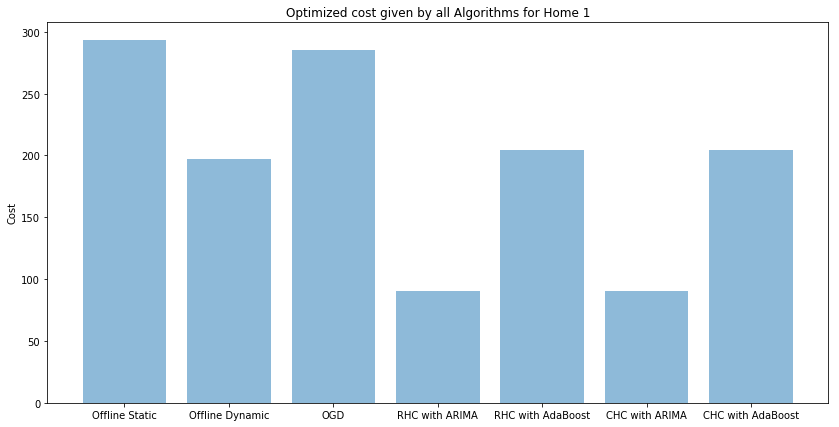

In [42]:
objects = ('Offline Static', 'Offline Dynamic', 'OGD', 'RHC with ARIMA', 'RHC with AdaBoost', 'CHC with ARIMA','CHC with AdaBoost')
y_pos = np.arange(len(objects))
performance = [293.07690,196.90778,285.29625,90.64281,204.60625,90.64211,204.605158]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Cost')
plt.title('Optimized cost given by all Algorithms for Home 1')
 
plt.show()

<h1> Deterministic algorithm with switch after every hour between 5 online algorithms </h1>

In [192]:
y = dataset['Actual'].tolist()
y_pred_arima = np.loadtxt("y_arima_pred_house1.csv")
y_pred_adaboost = np.loadtxt("y_adaboost_pred_house1.csv")
a = 1
b = 1
p = 0.1
n = 0.055
new_y = []

In [193]:
def OGD(t , x_best, cost):
    for i in range(0,4):
        new_y.append(y[t+i])
        x_best.append(x_best[t+i-1] - (n * df1(y[t+i-1], x_best[t+i-1] , x_best[t+i-2])))
        cost += p*x_best[t + i] + a*max(0, y[t + i] - x_best[t + i]) + b*abs(x_best[t + i] - x_best[t + i-1])
    return x_best , cost 

In [194]:
def RHC_ARIMA(t , x_best, cost):
    w = 12
    for i in range(0,4):
        new_y.append(y_pred_arima[t+i])
        y = y_pred_arima[t+i:t+w+i]
        x = cp.Variable(w)
        sum = 0
        for j in range(0,w):
            sum += (cp.multiply(p,x[j]) + cp.maximum(0, y[j]-x[j]) + cp.abs(x[j] - x[j-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        x_best.append(x.value[0])
        cost += p*x_best[t + i] + a*max(0, y_pred_arima[t + i] - x_best[t + i]) + b*abs(x_best[t + i] - x_best[t + i-1])
    return x_best , cost

In [195]:
def RHC_ADABOOST(t , x_best, cost):
    w = 12
    for i in range(0,4):
        new_y.append(y_pred_adaboost[t+i])
        y = y_pred_adaboost[t+i:t+w+i]
        x = cp.Variable(w)
        sum = 0
        for j in range(0,w):
            sum += (cp.multiply(p,x[j]) + cp.maximum(0, y[j]-x[j]) + cp.abs(x[j] - x[j-1]))

        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        x_best.append(x.value[0])
        cost += p*x_best[t + i] + a*max(0, y_pred_adaboost[t + i] - x_best[t + i]) + b*abs(x_best[t + i] - x_best[t + i-1])
    return x_best , cost

In [196]:
def CHC_ARIMA(t , x_best, cost):
    w = 5
    v = 2
    for i in range(0,4):
        new_y.append(y_pred_arima[t+i])
        y = y_pred_arima[t+i:t+w+i]
        x = cp.Variable(w)
        sum = 0
        for j in range(0,w):
            sum += (cp.multiply(p,x[j]) + cp.maximum(0, y[j]-x[j]) + cp.abs(x[j] - x[j-1]))
        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        avg = 0
        for j in range(0,v):
            avg += x.value[j]/v
        x_best.append(avg)
        cost += p*x_best[t + i] + a*max(0, y_pred_arima[t + i] - x_best[t + i]) + b*abs(x_best[t + i] - x_best[t + i-1])
    return x_best, cost

In [197]:
def CHC_ADABOOST(t , x_best, cost):
    w = 5
    v = 2
    for i in range(0,4):
        new_y.append(y_pred_adaboost[t+i])
        y = y_pred_adaboost[t+i:t+w+i]
        x = cp.Variable(w)
        sum = 0
        for j in range(0,w):
            sum += (cp.multiply(p,x[j]) + cp.maximum(0, y[j]-x[j]) + cp.abs(x[j] - x[j-1]))
        objective = (cp.Minimize(sum))
        constraints = [0 <= x]
        prob = cp.Problem(objective, constraints)
        result = prob.solve()
        avg = 0
        for j in range(0,v):
            avg += x.value[j]/v
        x_best.append(avg)
        cost += p*x_best[t + i] + a*max(0, y_pred_adaboost[t + i] - x_best[t + i]) + b*abs(x_best[t + i] - x_best[t + i-1])
    return x_best, cost

In [198]:
x_best_d = [0]
cost_d = 0
for t in range(1,35):
    x_best_d , cost_d = OGD(t , x_best_d, cost_d)
    x_best_d , cost_d = RHC_ARIMA(t + 4 , x_best_d, cost_d)
    x_best_d , cost_d = CHC_ARIMA(t + 8 , x_best_d, cost_d)
    x_best_d , cost_d = RHC_ADABOOST(t + 12 , x_best_d, cost_d)
    x_best_d , cost_d = CHC_ADABOOST(t + 16 , x_best_d, cost_d)

In [199]:
print(cost_d)

664.5838942934287


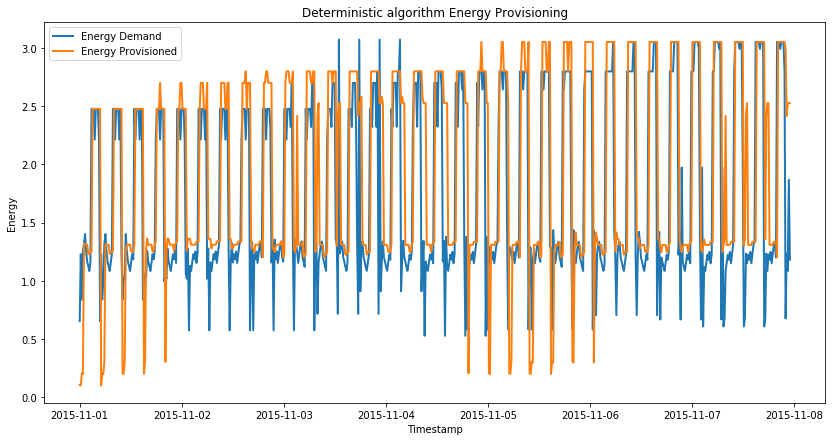

In [200]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 664).tolist()]
OD = pd.DataFrame({'Energy Provisioned': x_best_d[1:665]}) 
OD['Energy Demand'] = new_y[1:665]
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], linewidth=2, label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=2, label="Energy Provisioned")
plt.title('Deterministic algorithm Energy Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()

<h1> Randomized algorithm with switch after every hour between 5 online algorithms </h1>

In [188]:
import random
new_y = []
my_list = ['OGD'] * 10 + ['RHC_ARIMA'] * 25 + ['CHC_ARIMA'] * 30 + ['RHC_ADABOOST'] * 15 +  ['CHC_ADABOOST'] * 20
x_best_r = [0]
cost_r = 0
for t in range(1,35):
    x_best_r , cost_r = globals()[random.choice(my_list)](t , x_best_r, cost_r)
    x_best_r , cost_r = globals()[random.choice(my_list)](t + 4 , x_best_r, cost_r)
    x_best_r , cost_r = globals()[random.choice(my_list)](t + 8 , x_best_r, cost_r)
    x_best_r , cost_r = globals()[random.choice(my_list)](t + 12 , x_best_r, cost_r)
    x_best_r , cost_r = globals()[random.choice(my_list)](t + 16 , x_best_r, cost_r)

In [189]:
print(cost_r)

454.2840237970476


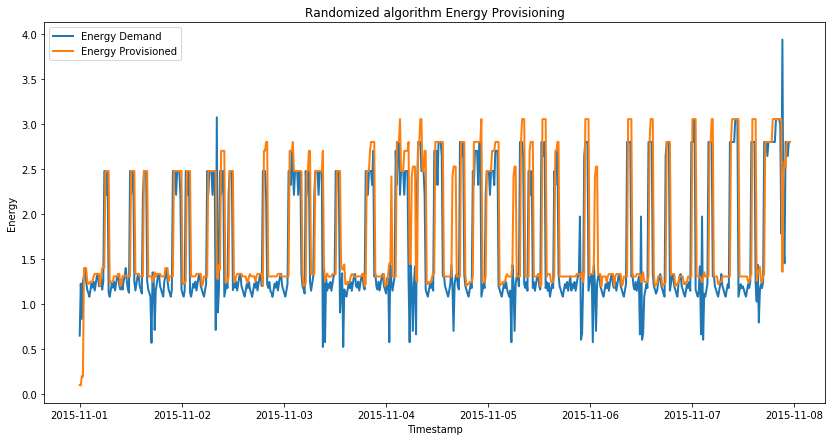

In [191]:
dur = [dt for dt in 
       pd.date_range(datetime(2015,11,1,0), datetime(2015, 11 , 7 , 23), 
       periods = 664).tolist()]
OD = pd.DataFrame({'Energy Provisioned': x_best_r[1:665]}) 
OD['Energy Demand'] = new_y[1:665]
OD['TimeStamp'] = dur
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
plt.plot(OD['TimeStamp'], OD['Energy Demand'], linewidth=2, label="Energy Demand")
plt.plot(OD['TimeStamp'], OD['Energy Provisioned'], linewidth=2, label="Energy Provisioned")
plt.title('Randomized algorithm Energy Provisioning')
plt.xlabel('Timestamp')
plt.ylabel('Energy')
plt.legend()
plt.show()